<img src="../logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Trabajo Práctico Nº8
#### Federico Borello

# Estimación Espectral de Potencia con Electrocardiograma

In [127]:
# @title: SetUp
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.io as sio

def vertical_flaten(a):
    return a.reshape(a.shape[0], 1)

# Seteo las Señales

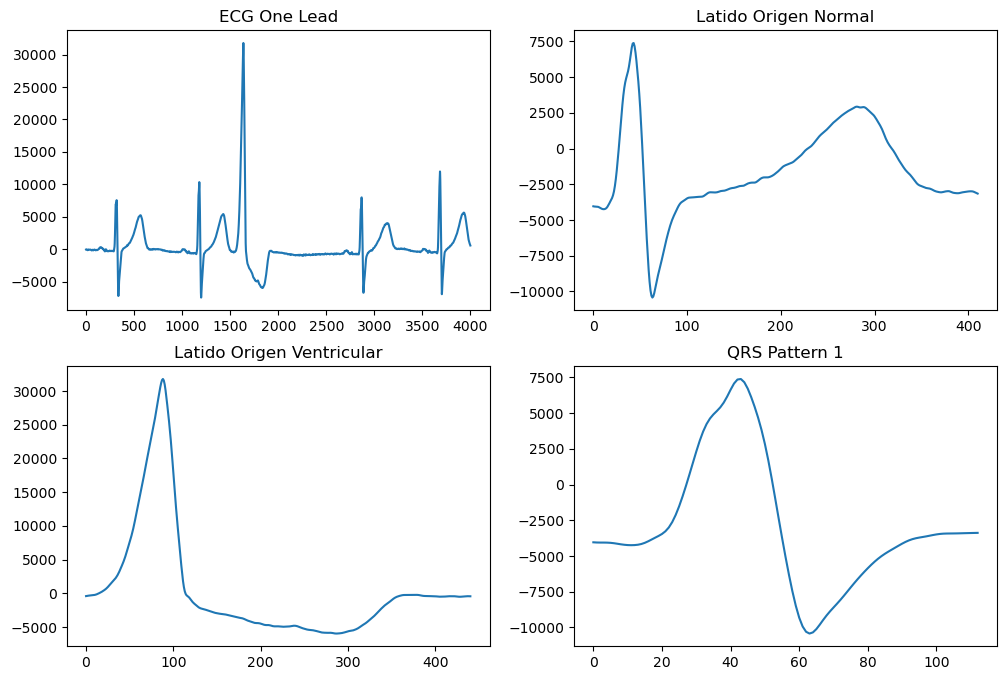

In [128]:
# Audio, ECG, PPG y Código original de la cátedra:
# https://github.com/marianux/pdstestbench/blob/4daeac9affd62217f4bafb8d7b8ec20834ba2a14/lectura_sigs.py

#######################################
# Lectura de Electrocardiograma (ECG) #
#######################################

# Información Util Sobre ECG:
# https://www.ncbi.nlm.nih.gov/books/NBK2214/

fs_ecg = 1000  # Hz

mat_struct = sio.loadmat("./ECG_TP4.mat")

ecg_one_lead = vertical_flaten(mat_struct["ecg_lead"])

# Latido normal
hb_1 = hb_n = vertical_flaten(mat_struct["heartbeat_pattern1"])
# Latido origen ventricular
hb_2 = hb_v = vertical_flaten(mat_struct["heartbeat_pattern2"])
# Complejo QRS normal
# https://en.wikipedia.org/wiki/QRS_complex
qrs_p1 = vertical_flaten(mat_struct["qrs_pattern1"])
# Vector de localización de los picos donde ocurren los latidos
qrs_d = vertical_flaten(mat_struct["qrs_detections"])

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(ecg_one_lead[24000:28000])
plt.title("ECG One Lead")

plt.subplot(2, 2, 2)
plt.plot(hb_1)
plt.title("Latido Origen Normal")

plt.subplot(2, 2, 3)
plt.plot(hb_2)
plt.title("Latido Origen Ventricular")

plt.subplot(2, 2, 4)
plt.plot(qrs_p1)
plt.title("QRS Pattern 1")

plt.show()

# Cálculo de la Estimación Espectral de Potencia

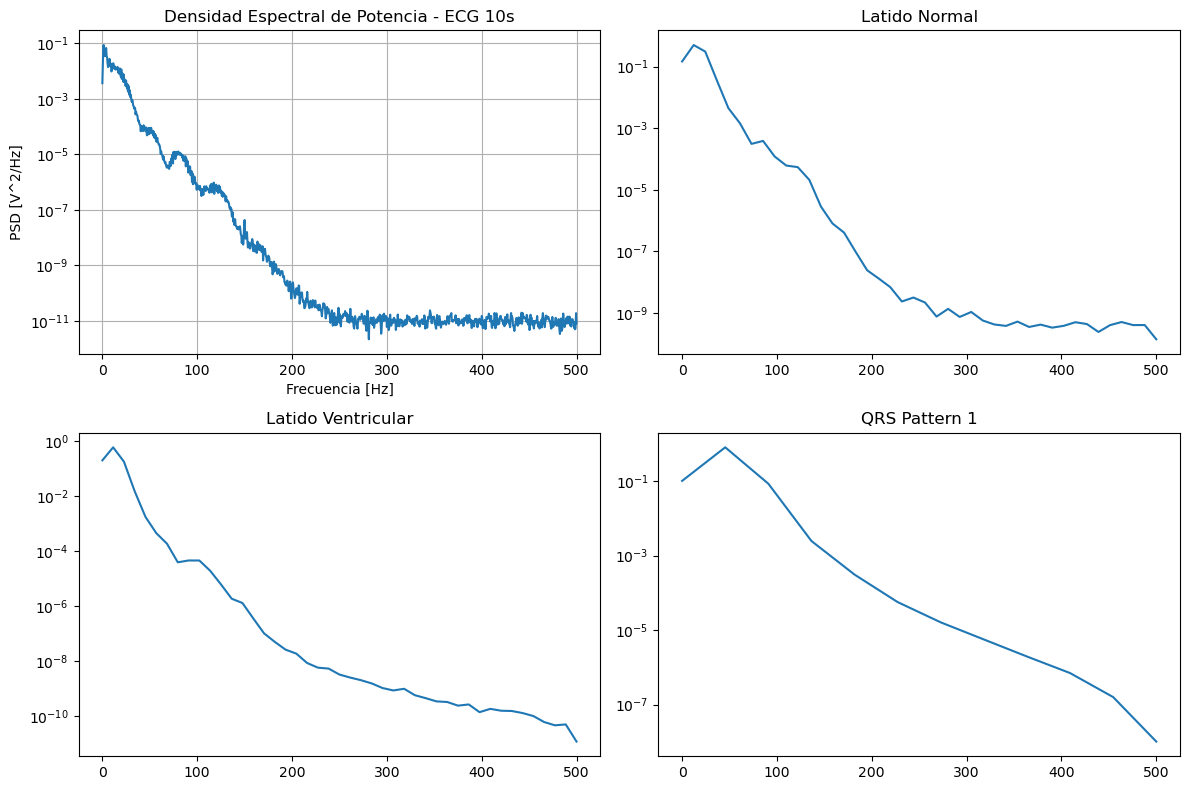

In [129]:
def calculate_psd_welch(signal_data, fs):
    # Seteo los "bins" del metodo welch a N/5, siendo N el largo de la señal.
    f, Pxx = signal.welch(signal_data, fs, nperseg=len(signal_data) // 5)
    Pxx_normalized = Pxx / np.sum(Pxx)
    return f, Pxx_normalized

plt.figure(figsize=(12, 8))

f, Pxx = calculate_psd_welch(ecg_one_lead[:10000].flatten(), fs_ecg)
plt.subplot(2, 2, 1)
plt.semilogy(f, Pxx)
plt.title("Densidad Espectral de Potencia - ECG 10s")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [V^2/Hz]")
plt.grid()

f, Pxx = calculate_psd_welch(hb_n[:10000].flatten(), fs_ecg)
plt.subplot(2, 2, 2)
plt.semilogy(f, Pxx)
plt.title("Latido Normal")

f, Pxx = calculate_psd_welch(hb_v[:10000].flatten(), fs_ecg)
plt.subplot(2, 2, 3)
plt.semilogy(f, Pxx)
plt.title("Latido Ventricular")

f, Pxx = calculate_psd_welch(qrs_p1[:10000].flatten(), fs_ecg)
plt.subplot(2, 2, 4)
plt.semilogy(f, Pxx)
plt.title("QRS Pattern 1")

plt.tight_layout()
plt.show()

# Se calcula la PSD de los latidos en ventanas específicas

La PSD de todas las realizaciones de latidos en una ventana que va desde ($R_i$ - 250 ms ; $R_i$ + 350 ms) para los i-ésimos latidos.

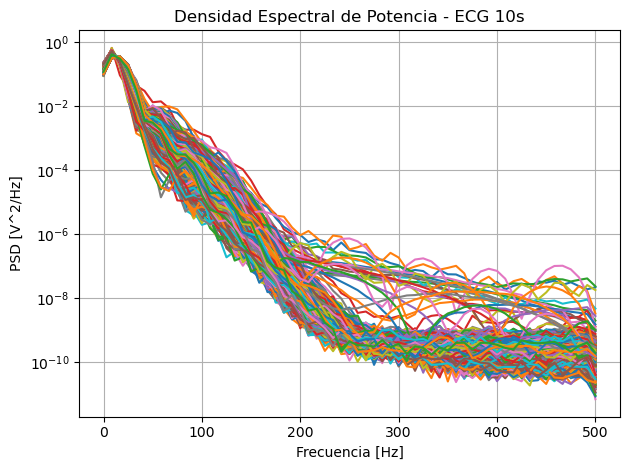

In [130]:
# Función para calcular la PSD en ventanas alrededor de los picos QRS
def calculate_windowed_ecg_psd_welch(ecg_data, fs, qrs_d):
    all_Pxx = []
    f = fs
    for r in qrs_d:
        if r < 250 or r > (len(ecg_data) - 350):
            continue
        window = ecg_data[int(r - 250) : int(r + 350)]
        f, Pxx = calculate_psd_welch(window, fs)
        all_Pxx.append(Pxx)

    # Promedio de todas las PSDs
    if len(all_Pxx) == 0:
        avg_Pxx = 0
    else:
        avg_Pxx = np.mean(all_Pxx)
    return f, all_Pxx, avg_Pxx

f_ecg_one_lead_n, all_Pxx_ecg_one_lead, avg_Pxx_ecg_one_lead = (
    calculate_windowed_ecg_psd_welch(ecg_one_lead.flatten(), fs_ecg, qrs_d)
)
for Pxx in all_Pxx_ecg_one_lead:
    plt.semilogy(f_ecg_one_lead_n, Pxx)
plt.title("Densidad Espectral de Potencia - ECG 10s")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [V^2/Hz]")
plt.grid()

plt.tight_layout()
plt.show()

# Se calcula la PSD de todo el Registro de ECG

In [134]:
def classify_heartbeats(ecg_signal, qrs_d):
    classifications = []

    for r in qrs_d:
        # Extraer el complejo QRS alrededor del pico R
        start_index = max(0, r - 250)  # 250 ms antes
        end_index = min(len(ecg_signal), r + 350)  # 350 ms después
        qrs_complex = ecg_signal[start_index:end_index]

        # Calcular la amplitud del complejo QRS
        amplitude = np.max(qrs_complex)

        # Clasificación basada en la amplitud
        if amplitude > 15000:
            classification = "Ventricular"
        elif amplitude < 5000:
            classification = "Normal"
        else:
            classification = "Unknown"  # Para amplitudes intermedias o no definidas

        classifications.append((r, classification))

    return classifications

classifications = classify_heartbeats(ecg_one_lead.flatten(), qrs_d.flatten().astype(int))

for index, label in classifications:
    print(f"Latido en índice {index}: {label}")

Latido en índice 482: Unknown
Latido en índice 1240: Unknown
Latido en índice 1986: Unknown
Latido en índice 2763: Unknown
Latido en índice 3562: Unknown
Latido en índice 4320: Unknown
Latido en índice 5109: Unknown
Latido en índice 5919: Unknown
Latido en índice 6731: Unknown
Latido en índice 7531: Unknown
Latido en índice 8433: Unknown
Latido en índice 8875: Ventricular
Latido en índice 10181: Unknown
Latido en índice 11119: Unknown
Latido en índice 12021: Unknown
Latido en índice 12958: Unknown
Latido en índice 13920: Unknown
Latido en índice 14826: Unknown
Latido en índice 15754: Unknown
Latido en índice 16818: Unknown
Latido en índice 17801: Unknown
Latido en índice 18775: Unknown
Latido en índice 19744: Unknown
Latido en índice 20683: Unknown
Latido en índice 21614: Unknown
Latido en índice 22527: Unknown
Latido en índice 23439: Unknown
Latido en índice 24315: Unknown
Latido en índice 25176: Unknown
Latido en índice 25640: Ventricular
Latido en índice 26865: Unknown
Latido en índ